## Some Exploratory Data Analysis
By Jackson Isidor and Alex Sullivan

Looking at variation and distributions for seeds and conferances. This ties into predictor variables of elite strength of schedule and talent. 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import numpy as np

In [25]:
df_raw = pd.read_csv("raw_stats1.csv")
df_raw["SEED"].unique()
df_raw=df_raw[df_raw["ROUND"] != 68]

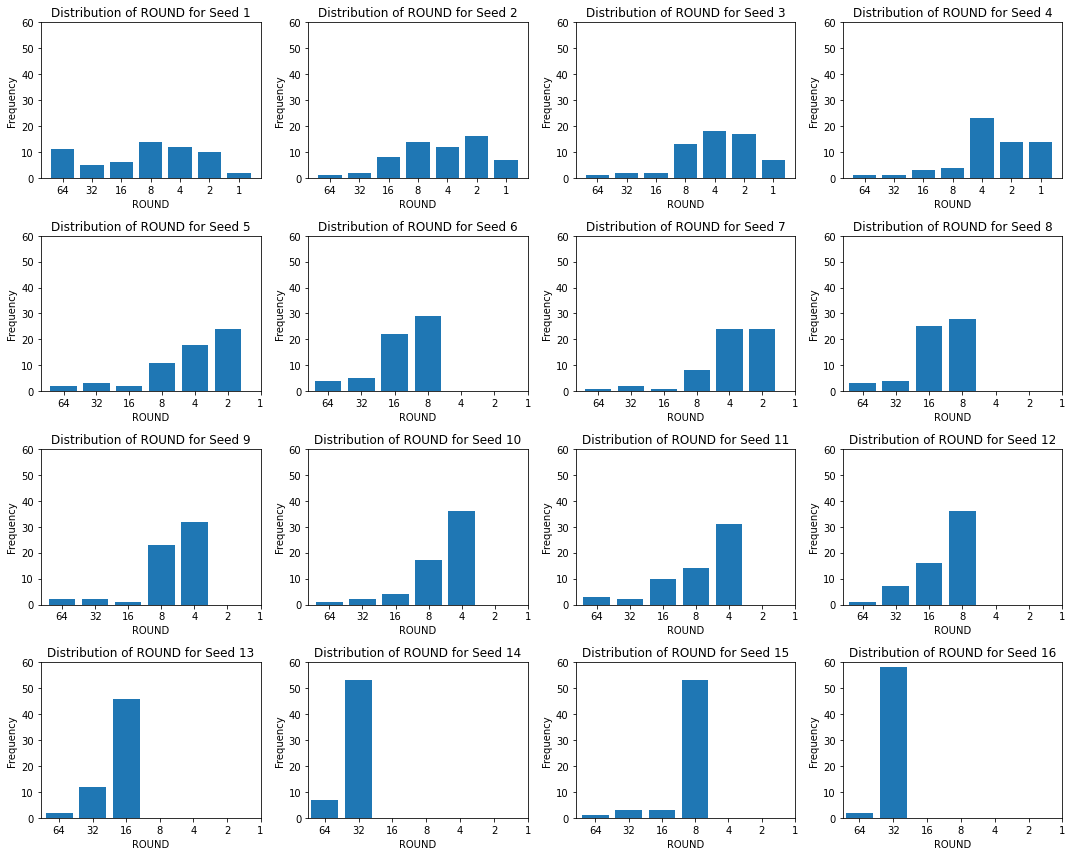

In [26]:

tick_labels = ["64", "32", "16", "8", "4", "2", "1"]

tick_positions = range(len(tick_labels))

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

for seed_val, ax in zip(range(1, 17), axes.flatten()):
    df_seed = df_raw[df_raw["SEED"] == seed_val]
    
    round_counts = df_seed["ROUND"].value_counts().sort_index()
    

    ax.bar(round_counts.index.astype(str), round_counts.values)
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("ROUND")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of ROUND for Seed {}".format(seed_val))
    ax.set_ylim(0, 60)


plt.tight_layout()



plt.show()


First glance at the graphs seems fairly inuitive but there are some suprising observtions such as a muiltple seed 15s have made it past round 8 but a seed 13 has never made it past the sweet 16. More spread in data for earlier seeds. Data for later seeds tends to hug right side of the x axis

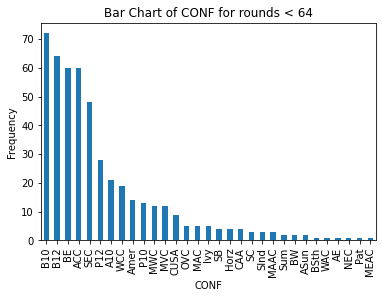

<Figure size 432x288 with 0 Axes>

In [27]:
df_win = df_raw[df_raw["ROUND"] < 64]
df_win["CONF"].value_counts().plot(kind="bar")
plt.xlabel("CONF")
plt.ylabel("Frequency")
plt.title("Bar Chart of CONF for rounds < 64")
plt.show()
plt.savefig('conf.png')

The graph shows a bar chart of the conferances and the number of wins they have achieved in the march madness tournametn (defined one win as making it past the round of 64). Demonstrates that some conferances such as the Big 10, Big 12, and Big East tend to dominate the tournament. This times into the elite strength of schedule as teams within these conferances will have a stronger schedule and feel more prepared going into March Madness

### Some preprocessing

In [28]:
matchups = pd.read_csv("matchups.csv")
matchups.columns
matchups["seed_diff"] = matchups["seed_1"] - matchups["seed_2"]
matchups=matchups[matchups["seed_1"] != 68]
matchups=matchups[matchups["seed_2"] != 68]

In [29]:
#function to get all combonations of features to see who has the most impact

def getFeatures(allFeatures, j):
    binary_str = bin(j)[2:].zfill(len(allFeatures))
    subset = [allFeatures[i] for i in range(len(allFeatures)) if binary_str[i] == '1']
    return subset

featureList =["badj_em_diff", "wab_diff", "barthag_diff", "talent_diff", "elite_sos_diff", "win_percent_diff", "pppo_diff", "k_off_diff","seed_diff"]
featList = []
for i in range(1, 255):
        featList.append(getFeatures(featureList, i))

## Testing Models
We want to get an preliminary idea of which predictor will be the best to use in our bracket simulation. We looked at KNeighbors and Logisitc Regression's ability to predict the winner with 5 folds. 

In [31]:
#Does a grid search of parameters and manually looks for best combo with features

model = make_pipeline(StandardScaler(), KNeighborsClassifier())

param_grid = {'kneighborsclassifier__n_neighbors': list(range(3, 26)),
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__p': [1, 2]}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')

best_params = None
best_score = float("-inf")
feat=[]

# Perform grid search for each feature set
for f in featList:
    grid_search.fit(matchups[f], matchups["winner"])
    
    # Update best parameters and score if necessary
    if grid_search.best_score_ > best_score:
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best = f


print("Best Parameters:", grid_search.best_params_)
print("Best Score (Accuracy):", grid_search.best_score_)
print(best)

Best Parameters: {'kneighborsclassifier__n_neighbors': 22, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
Best Score (Accuracy): 0.7029019003595275
['wab_diff', 'talent_diff', 'win_percent_diff']


In [34]:
#Does cross validation for Logistic regression and loops through combination of features
model = make_pipeline(StandardScaler(), LogisticRegression())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = float("-inf")
best_feat = None


for f in featList:
    cv_score = cross_val_score(model, X=matchups[f], y=matchups["winner"], cv=kf, scoring='accuracy')
    mean_cv_score = np.mean(cv_score)
    
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_feat = f

print("Best Score (Accuracy):", best_score)
print("Best Feature Set:", best_feat)

Best Score (Accuracy): 0.7244350282485875
Best Feature Set: ['wab_diff', 'barthag_diff']


Logistic regression performed slightly better than KNeighbors with 72% accuracy. However this was just a quick look at the model and it uses a larger chunk of the data set. When running this to predict the bracket the training set will be smaller which will have an effect on the accuracy. 